# Analyses of the paper

This notebook is doing the figures and the statistics for the paper. To use this notebook you need forst to create the jsons using `data_protnaff.ipynb`.

This notebook is quite big, you will need to run every cell in order to obtain all figures from the paper, it can take 1 hour.

First testing if the installation is correct.

In [1]:
%%bash 

if [[ -z "$PROTNAFF" ]]; then
    echo "You did not do the installation correctly, please refer to the INSTALLATION.md"
else
    if [[ -f "$PATH/x3dna-dssr" ]]; then
        echo "x3dna-dssr is not correctly installed."
    else
        echo "The installation seems correct."
    fi
fi

The installation seems correct.


Then the importation of all python packages needed to run this notebook, but also a test to know if you run the `create_json.ipynb`.

In [2]:
import os
import json
import numpy as np

#The packages for statistics
import scipy.stats
from statsmodels.stats.proportion import proportions_ztest

#The graphics libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

if not os.path.isfile("./data_paper/structures.json") or not os.path.isfile("./data_paper/fragments.json"):
    print("You need to run the data_protnaff.ipynb first.")
else:
    print("You can continue.")

You can continue.


The `structures` and `fragments` dictionnaries will be used in several cells.

In [3]:
structures = json.load(open("./data_paper/structures.json"))
fragments = json.load(open("./data_paper/fragments_clust.json"))

In [4]:
fragments['AAA']['1']

{'chain': 'B',
 'clust0.2': 1,
 'clust0.2_center': True,
 'clust1.0': 1,
 'clust1.0_center': False,
 'clust3.0': 1,
 'clust3.0_center': False,
 'indices': [1, 2, 3],
 'missing_atoms': [0, 0, 0],
 'model': 1,
 'resid': ['201', '202', '203'],
 'seq': 'GGA',
 'structure': '1A1T'}

## Do NMR structures contain more ssRNA than X-ray structures?

Here are simple statistics, the `structures` is parsed, and for each structure, the experimental method is count as x-ray or nmr.

Then a percentage of each method is made and an exact fisher test is performed to know if the results are different or not.

In [4]:
result = {"x-ray":{"ss":0, "ds":0}, "nmr":{"ss":0, "ds":0}}

x = 0
n = 0

for value in structures.values():
    if value["method"] == "x-ray diffraction":
        x += 1
        for chain in value['ss'].values():
            for res in chain.values():
                if res[0] == "D":
                    result["x-ray"]["ds"] += 1
                else:
                    result["x-ray"]["ss"] += 1
    elif value["method"] == "solution nmr" or value["method"] == "solution nmr; theoretical model" or value["method"] == "solid-state nmr":
        n += 1
        for chain in value['ss'].values():
            for res in chain.values():
                if res[0] == "D":
                    result["nmr"]["ds"] += 1
                else:
                    result["nmr"]["ss"] += 1
print(result)
x_per = round((result["x-ray"]['ss']*100/(result["x-ray"]['ss'] + result["x-ray"]['ds'])),2)
rmn_per = round((result["nmr"]['ss']*100/(result["nmr"]['ss']+result["nmr"]['ds'])),2)
print("Percentages ss: X-ray: {}%, NMR: {}%".format(x_per, rmn_per))

(oddsratio, pvalue) = scipy.stats.fisher_exact([[result["x-ray"]['ss'], result["nmr"]['ss']], [result["x-ray"]['ds'], result["nmr"]['ds']]])
print("The p-value of the exact fisher test is: {:.3f}".format(pvalue))

{'x-ray': {'ss': 95001, 'ds': 151583}, 'nmr': {'ss': 1244, 'ds': 2010}}
Percentages ss: X-ray: 38.53%, NMR: 38.23%
The p-value of the exact fisher test is: 0.744


## Conformational diversity of RNA fragments at different scales

The first cell is making the figure showing the number of elements in the clusters at 1A and 3A.

The second cell is showing in details the composition of those clusters, by printing the number of clusters of a given size (number of elements).

The next cell is doing the Figure 2 of the paper (link).

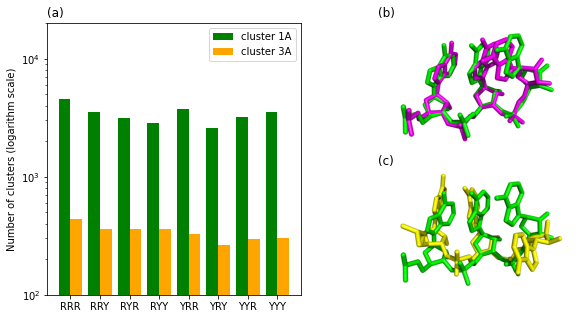

In [6]:
tick = ["RRR", "RRY", "RYR", "RYY", "YRR", "YRY", "YYR", "YYY"]
motifs = ['AAA', 'AAC', 'ACA', 'ACC', 'CAA', 'CAC', 'CCA', 'CCC']
clust_1A = []
clust_3A = []
for motif in motifs:
    with open("./data_paper/trilib/{}-dr0.2r-clust1.0".format(motif)) as ff:
        for n_line_1A, _ in enumerate(ff):
            pass
        clust_1A.append(n_line_1A)
    with open("./data_paper/trilib/{}-dr0.2r-clust1.0-clust3.0".format(motif)) as ff3:
        for n_line_3A, _ in enumerate(ff3):
            pass
        clust_3A.append(n_line_3A)

plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[:, 0])
ax.set_title('(a)', loc='left')
plt.bar([1, 2, 3, 4, 5, 6, 7, 8], clust_1A, 0.4, label="cluster 1A", log=True, color='green')
plt.bar([1.4, 2.4, 3.4, 4.4, 5.4, 6.4, 7.4, 8.4], clust_3A, 0.4, label="cluster 3A", log=True, color='orange')
plt.ylabel("Number of clusters (logarithm scale)")
plt.xticks([1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2], tick)
plt.ylim(100, 20000)
plt.legend()
ax = plt.subplot(gs[0, 1])
ax.set_title('(b)', loc='left')
img = mpimg.imread('./alignement_1A.png')
imgplot = plt.imshow(img)
plt.axis('off')
ax = plt.subplot(gs[1, 1])
ax.set_title('(c)', loc='left')
img = mpimg.imread('./alignement_3A.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.savefig('fig2.png', facecolor="w")
plt.show()

The next cell is doing the Figure 3 of the paper.

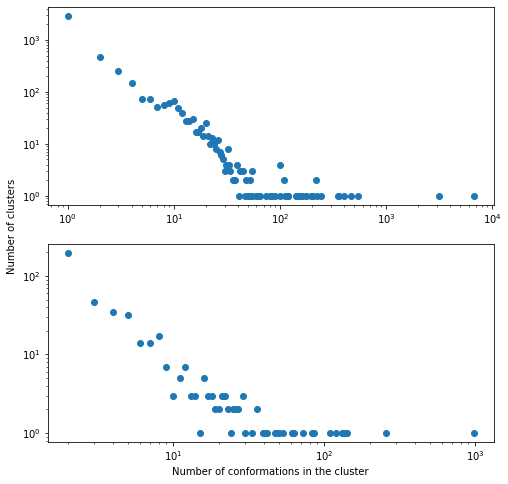

In [7]:
def create_fig3(file_cluster):
    with open(file_cluster) as ff:
        lines = ff.readlines()
    res = {}
    for line in lines:
        line = line.split(' ')
        len_line = len(line) - 4
        if len_line in res.keys():
            res[len_line] += 1
        else:
            res[len_line] = 1
    return res

res_1A = create_fig3("./data_paper/trilib/AAA-dr0.2r-clust1.0")
res_3A = create_fig3("./data_paper/trilib/AAA-dr0.2r-clust1.0-clust3.0")
        
# Then creation of plots
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(res_1A.keys(), res_1A.values())
ax1.set_xscale("log")
ax1.set_yscale("log")
ax2 = plt.subplot(gs[1, 0])
ax2.scatter(res_3A.keys(), res_3A.values())
ax2.set_xscale("log")
ax2.set_yscale("log")

fig.text(0.055, 0.5, "Number of clusters", va='center', rotation='vertical')
plt.xlabel("Number of conformations in the cluster")
plt.savefig("fig3.png", facecolor="w", bbox_inches='tight')
plt.show()

## RNA local conformations induced by protein binding

In this part of the paper, we are interested in the conformations that are induced by the contact with the protein. To understand if the contact with the protein is implying particular conformations, we are parsing the `fragments` dictionnary and extracting the informations about all clusters. The clusters can be fully single-strande, or fully double stranded or a mix of ss and ds conformations. They also can be fully in contact or fully not in contact or a mix betwwen contact and no contact with the protein.

In [8]:
def parsing_fragments(fragments, structures, cutoff):
    """
    This function will parse the fragments dictionnary to extract information about clusters, 
    then it will parse those clusters to extract their properties.
    results are the results for each clusters
    res_bis is a sum of information by clusters
    """
    results = {"AAA":{}, "AAC":{}, "ACA":{}, "ACC":{}, "CAA":{}, "CAC":{}, "CCA":{}, "CCC":{}}
    res_bis = {"AAA":{}, "AAC":{}, "ACA":{}, "ACC":{}, "CAA":{}, "CAC":{}, "CCA":{}, "CCC":{}}
    for key in results.keys():
        for key2 in fragments[key].keys():
            model = "model_" + str(fragments[key][key2]["model"])
            chain = "chain_" + str(fragments[key][key2]["chain"])
            contact = False
            interface = set()
            for nucl in structures[fragments[key][key2]['structure']]["interface_protein"]["model_1"][chain].keys():
                interface.add(nucl.split('_')[1])
            ss=True
            ds=0
            for nucl in fragments[key][key2]['indices']:
                if str(nucl) in interface:
                    contact = True
                if structures[fragments[key][key2]['structure']]["ss"][chain]["res_"+str(nucl)][0]=="D":
                    ss=False
                    ds+=1
            if fragments[key][key2][cutoff] not in results[key].keys():
                results[key][fragments[key][key2][cutoff]] = {"contact_ss":0, "contact_ds":0, "contact_mixte":0, "nocontact_ss":0, "nocontact_ds":0, "nocontact_mixte":0}
            if contact:
                if ss:
                    results[key][fragments[key][key2][cutoff]]["contact_ss"] += 1
                elif ds == 3:
                    results[key][fragments[key][key2][cutoff]]["contact_ds"] += 1
                else:
                    results[key][fragments[key][key2][cutoff]]["contact_mixte"] += 1
            else:
                if ss:
                    results[key][fragments[key][key2][cutoff]]["nocontact_ss"] += 1
                elif ds == 3:
                    results[key][fragments[key][key2][cutoff]]["nocontact_ds"] += 1
                else:
                    results[key][fragments[key][key2][cutoff]]["nocontact_mixte"] += 1
        con_ss = 0
        sum_con_ss = 0
        con_ds = 0
        sum_con_ds = 0
        con_mixte = 0
        sum_con_mixte = 0
        nocon_ss = 0
        sum_nocon_ss = 0
        nocon_ds = 0
        sum_nocon_ds = 0
        nocon_mixte = 0
        sum_nocon_mixte = 0
        mixte_ss = 0
        sum_mixte_ss = 0
        mixte_ds = 0
        sum_mixte_ds = 0
        mixte_mixte = 0
        sum_mixte_mixte=0
        for clust in results[key].keys():
            #if there is at least 3 fragments in the cluster:
            if results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"] + results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"] > 2:
                if results[key][clust]["nocontact_mixte"] == 0 and results[key][clust]["nocontact_ds"] == 0 and results[key][clust]["nocontact_ss"] == 0:
                    if results[key][clust]["contact_mixte"] > 0:
                        con_mixte += 1
                        sum_con_mixte += results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"]
                    else:
                        if results[key][clust]["contact_ds"] == 0:
                            con_ss += 1
                            sum_con_ss += results[key][clust]["contact_ss"]
                        else:
                            con_ds += 1
                            sum_con_ds += results[key][clust]["contact_ds"]
                elif results[key][clust]["contact_ss"] == 0 and results[key][clust]["contact_ds"] == 0 and results[key][clust]["contact_mixte"] == 0:
                    if results[key][clust]["nocontact_mixte"] > 0:
                        nocon_mixte += 1
                        sum_nocon_mixte += results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"]
                    else:
                        if results[key][clust]["nocontact_ss"] == 0:
                            nocon_ds += 1
                            sum_nocon_ds += results[key][clust]["nocontact_ds"]
                        else:
                            nocon_ss += 1
                            sum_nocon_ss += results[key][clust]["nocontact_ss"]
                else:
                    if results[key][clust]["nocontact_mixte"] > 0 or results[key][clust]["contact_mixte"] > 0 or (results[key][clust]["nocontact_ss"] != 0 and results[key][clust]["nocontact_ds"] !=0) or (results[key][clust]["contact_ss"] != 0 or results[key][clust]["contact_ds"] !=0):
                        mixte_mixte += 1
                        sum_mixte_mixte += results[key][clust]["nocontact_ss"] + results[key][clust]["nocontact_ds"] + results[key][clust]["nocontact_mixte"] + results[key][clust]["contact_ss"] + results[key][clust]["contact_ds"] + results[key][clust]["contact_mixte"]
                    else:
                        if results[key][clust]["contact_ss"] == 0 and results[key][clust]["nocontact_ss"] == 0:
                            mixte_ds += 1
                            sum_mixte_ds += results[key][clust]["nocontact_ds"] + results[key][clust]["contact_ds"]
                        else:
                            mixte_ss += 1
                            sum_mixte_ss += results[key][clust]["contact_ss"] + results[key][clust]["nocontact_ss"]             

        res_bis[key] = {"contact_ss":con_ss, "contact_ds":con_ds, "contact_mixte":con_mixte, "nocontact_ss":nocon_ss, "nocontact_ds":nocon_ds, "nocontact_mixte":nocon_mixte, "mixte_ss":mixte_ss, "mixte_ds":mixte_ds, "mixte_mixte":mixte_mixte, \
                       "sum_contact_ss":sum_con_ss, "sum_contact_ds":sum_con_ds, "sum_contact_mixte":sum_con_mixte, \
                       "sum_nocontact_ss":sum_nocon_ss, "sum_nocontact_ds":sum_nocon_ds, "sum_nocontact_mixte":sum_nocon_mixte,\
                       "sum_mixte_ss":sum_mixte_ss, "sum_mixte_ds":sum_mixte_ds, "sum_mixte_mixte":sum_mixte_mixte}

    return results, res_bis

In [9]:
results_1A, res_cluster_1A = parsing_fragments(fragments, structures, 'clust1.0')
results_3A, res_cluster_3A = parsing_fragments(fragments, structures, 'clust3.0')

The next cell is making Figure.4 of the paper.

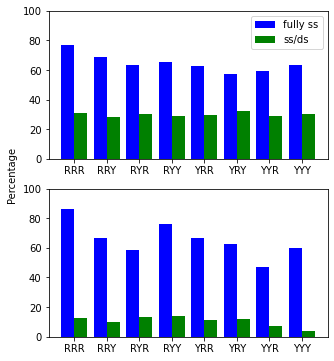

In [10]:
hist={"AAA":[], "AAC":[], "ACA":[], "ACC":[], "CAA":[], "CAC":[], "CCA":[], "CCC":[]}
tick = ["RRR", "RRY", "RYR", "RYY", "YRR", "YRY", "YYR", "YYY"]

for key in res_cluster_1A.keys():
    hist[key].append(round((100*(res_cluster_1A[key]["contact_ss"]/(res_cluster_1A[key]["contact_ss"]+res_cluster_1A[key]["mixte_ss"]+res_cluster_1A[key]["nocontact_ss"]))),2))
    hist[key].append(round((100*((res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["contact_ds"])/(res_cluster_1A[key]["contact_mixte"]+res_cluster_1A[key]["mixte_mixte"]+res_cluster_1A[key]["nocontact_mixte"]+res_cluster_1A[key]["contact_ds"]+res_cluster_1A[key]["mixte_ds"]+res_cluster_1A[key]["nocontact_ds"]))),2))

a = [row[0] for row in list(hist.values())]
b = [row[1] for row in list(hist.values())]

hist_3A={"AAA":[], "AAC":[], "ACA":[], "ACC":[], "CAA":[], "CAC":[], "CCA":[], "CCC":[]}

for key in res_cluster_3A.keys():
    hist_3A[key].append(round((100*(res_cluster_3A[key]["contact_ss"]/(res_cluster_3A[key]["contact_ss"]+res_cluster_3A[key]["mixte_ss"]+res_cluster_3A[key]["nocontact_ss"]))),2))
    hist_3A[key].append(round((100*((res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["contact_ds"])/(res_cluster_3A[key]["contact_mixte"]+res_cluster_3A[key]["mixte_mixte"]+res_cluster_3A[key]["nocontact_mixte"]+res_cluster_3A[key]["contact_ds"]+res_cluster_3A[key]["mixte_ds"]+res_cluster_3A[key]["nocontact_ds"]))),2))

a_3A = [row[0] for row in list(hist_3A.values())]
b_3A = [row[1] for row in list(hist_3A.values())]

fig4 = plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(2, 1)

x1= [i-0.2 for i in range(8)]
x2= [i+0.2 for i in range(8)]

ax1 = plt.subplot(gs[0, 0])
ax1.bar(x1, a, width=0.4, color='b', align='center', label="fully ss")
ax1.bar(x2, b, width=0.4, color='g', align='center', label="ss/ds")
ax1.xaxis.set_ticks(range(8))
ax1.xaxis.set_ticklabels(tick, color="black")
ax1.set_ylim(0,100)

ax2 = plt.subplot(gs[1, 0])
ax2.bar(x1, a_3A, width=0.4, color='b', align='center', label="fully ss")
ax2.bar(x2, b_3A, width=0.4, color='g', align='center', label="ss/ds")
ax2.xaxis.set_ticks(range(8))
ax2.xaxis.set_ticklabels(tick, color="black")
ax2.set_ylim(0,100)

fig4.text(0.01, 0.5, 'Percentage', va='center', rotation='vertical')
ax1.legend(loc="upper right")

plt.savefig("fig4.png", facecolor="w")
plt.show()


In [11]:
for motif in res_cluster_1A.keys():
    ss = res_cluster_1A[motif]["contact_ss"]+res_cluster_1A[motif]["nocontact_ss"]+res_cluster_1A[motif]["mixte_ss"]
    mixte = res_cluster_1A[motif]["contact_ds"]+res_cluster_1A[motif]["nocontact_ds"]+res_cluster_1A[motif]["mixte_ds"]+res_cluster_1A[motif]["contact_mixte"]+res_cluster_1A[motif]["nocontact_mixte"]+res_cluster_1A[motif]["mixte_mixte"]
    successes = np.array([res_cluster_1A[motif]["contact_ss"], res_cluster_1A[motif]["contact_ds"] + res_cluster_1A[motif]["contact_mixte"]])
    samples = np.array([ss, mixte])

    stat, p_value = proportions_ztest(count=successes, nobs=samples, alternative='two-sided')

    print(motif, stat, p_value)

AAA 14.426673533481148 3.516359604220953e-47
AAC 10.901514218991478 1.1335495850514012e-27
ACA 8.725639104212846 2.646815278234539e-18
ACC 8.197058021159087 2.4634156150318583e-16
CAA 9.489023712068445 2.33208114703926e-21
CAC 5.99411214361468 2.0460015216670207e-09
CCA 7.199428079406214 6.046563930645146e-13
CCC 8.445348256825527 3.0314037048276336e-17


The next cell is showing the values in the Figure.5 of the paper.

In [12]:
print("           ss  mixte  ds  ")
print("nocontact ",res_cluster_1A['AAA']['nocontact_ss']," ", res_cluster_1A['AAA']['nocontact_mixte'], " ",res_cluster_1A['AAA']['nocontact_ds'])
print("mixte       ", res_cluster_1A['AAA']['mixte_ss'], "", res_cluster_1A['AAA']['mixte_mixte'], " ", res_cluster_1A['AAA']['mixte_ds'])
print("contact   ",res_cluster_1A['AAA']['contact_ss'], " ",res_cluster_1A['AAA']['contact_mixte'], "", res_cluster_1A['AAA']['contact_ds'])

           ss  mixte  ds  
nocontact  78   154   8
mixte        0  510   0
contact    255   289  17


## Size of interfaces in protein-bound RNA hairpin loops

In this part we are interested into hairpins, they are a particular secondary structure of the RNA. We will create a benchmark of hairpins here and then have a look at the number of nucleotides in contact with the protein.

In [32]:
with open("/data1/amoniot/NAfragDB_am2/NAfragDB/create_benchmark/queries/rna_contact_ss3_ds3_deredundant2.list") as f:
    lines = f.readlines()
print(len(lines))
lines = list(set(lines))
print(len(lines))

2642
1311


In [167]:
%%bash

cd $PROTNAFF/data_paper
python $PROTNAFF/create_benchmark/filters/query_hairpin.py 3dna/ structures.json test_hairpin.list --ss 3 --ds 3 --contact 0

1A1T
1A34
1A4T
1A9N
1AQ3
1AQ4
1ASY
1ASZ
1AUD
1AV6
1B23
1B7F
1BIV
1BMV
1C0A
1C9S
1CVJ
1D6K
1DDL
1DFU
1DI2
1DK1A
1DK1B
1DRZ
1DUL
1DZ5
1E7K
1EC6
1EFW
1EKZ
1ETF
1ETG
1EUY
1EXD
1EXY
1F6U
1F7U
1F7V
1F7YA
1F7YB
1F8V
1FEU
1FFK
1FFY
1FJE
1FJG
1FNX
1FXL
1G1X
1G2E
1G59
1G70
1GAX
1GTF
1GTN
1GTR
1GTS
1H2C
1H2D
1H38
1H3E
1H4Q
1H4S
1HC8
1HJI
1HQ1
1HYS
1I5L
1I6U
1I9F
1IL2
1IVS
1J1U
1JBR
1JBS
1JBT
1JID
1JJ2
1K1G
1K8A
1K8W
1K9M
1KD1
1KNZ
1KQ2
1KUQA
1KUQB
1L1C
1L9A
1LNG
1M5K
1M5O
1M5P
1M5V
1M8V
1M8WA
1M8WB
1M8X
1M8Y
1M90
1MJI
1MMS
1MNB
1MSW
1MZP
1N1H
1N32
1N35
1N38
1N77
1N78
1N8R
1NB7
1NJI
1NYB
1O0B
1O0C
1OLN
1OOA
1PGL
1Q2R
1Q81
1Q82
1Q86
1QA6
1QF6
1QFQ
1QLN
1QRS
1QRT
1QRU
1QTQ
1QU2
1QU3
1QVG
1R3E
1R9F
1RC7
1RGO
1RKJ
1RLG
1RMV
1RPUA
1RPUB
1S03
1S72
1S76
1S77
1SDS
1SER
1SI2
1SI3
1SJ3
1SJ4
1SJF
1T4L
1TFW
1TTT
1U0B
1U1Y
1U6P
1ULL
1URN
1UTD
1UVI
1UVJ
1UVL
1UVM
1UVN
1VBX
1VBY
1VBZ
1VC0
1VC6
1VFG
1VQ4
1VQ5
1VQ6
1VQ7
1VQ8
1VQ9
1VQK
1VQL
1VQM
1VQN
1VQO
1VQP
1WMQ
1WNE
1WPU
1WRQ
1WSU
1WWD
1WWE
1WWF
1WWG
1XMQ
1XOK


In [168]:
with open("./data_paper/test_hairpin.list") as ff:
    lines2 = ff.readlines()

In [114]:
hairpins = []
for line in lines:
    try:
        tmp = line.rstrip().split()
        tmp[2] = int(tmp[2][2:-2])
        tmp[3] = int(tmp[3][1:-2])
        if len(tmp[-1]) == tmp[3] - tmp[2] + 1:
            hairpins.append(tmp)
    except:
        pass
print(len(hairpins))

1136


In [169]:
hairpins2 = []
for line in lines2:
    try:
        tmp = line.rstrip().split()
        tmp[2] = int(tmp[2][2:-2])
        tmp[3] = int(tmp[3][1:-2])
        if len(tmp[-1]) == tmp[3] - tmp[2] + 1:
            hairpins2.append(tmp)
    except:
        pass
print(len(hairpins2))

5619
5208


In [170]:
set1 = set()
set2 = set()
for line in hairpins:
    set1.add(line[0])
for line in hairpins2:
    set2.add(line[0])

In [171]:
print(len(set1))
print(len(set2))
print(len(set1.intersection(set2)))

360
610
158


In [172]:
results_hairpins = {}
for hairpin in hairpins2:
    print(hairpin)
    try:
        if hairpin[0] not in results_hairpins.keys():
            results_hairpins[hairpin[0]] = {}
        if structures[hairpin[0]]["method"] == "solide nmr" or structures[hairpin[0]]["method"] == "solution nmr" or structures[hairpin[0]]["resolution"] < 3:
            jj = len(results_hairpins[hairpin[0]].keys())
            results_hairpins[hairpin[0]][jj] = {"contact_ss":0, "contact_ds":0, "nocontact":0}
            chain = "chain_" + hairpin[1]
            interface = set()
            for nucl in structures[hairpin[0]]["interface_protein"]["model_1"][chain].keys():
                tmp = nucl.split('_')[1]
                interface.add(structures[hairpin[0]]["mapping"][chain][tmp])
            for ii in range(hairpin[2], hairpin[3]+1):
                if str(ii) in interface:
                    if int(ii) - hairpin[2] < 3 or hairpin[3] - int(ii) < 3:
                        results_hairpins[hairpin[0]][jj]["contact_ds"] += 1
                    else:
                        results_hairpins[hairpin[0]][jj]["contact_ss"] += 1
                else:
                    results_hairpins[hairpin[0]][jj]["nocontact"] += 1
    except:
        pass

['1A1T', 'B', 206, 215, 'AGCGGAGGCU']
['1A4T', 'A', 6, 16, 'GCUGACAAAGC']
['1A9N', 'Q', 2, 20, 'UGGUAUUGCAGUACCUCCA']
['1A9N', 'R', 2, 20, 'UGGUAUUGCAGUACCUCCA']
['1ASY', 'R', 611, 624, 'UUUAAUGGUCAGAA']
['1ASY', 'R', 629, 641, 'CGCUUGUCGCGUG']
['1ASY', 'R', 651, 663, 'GGGUUCAAUUCCC']
['1ASY', 'S', 611, 624, 'UUUAAUGGUCAGAA']
['1ASY', 'S', 629, 641, 'CGCUUGUCGCGUG']
['1ASY', 'S', 651, 663, 'GGGUUCAAUUCCC']
['1ASZ', 'R', 611, 624, 'UUUAAUGGUCAGAA']
['1ASZ', 'R', 629, 641, 'CGCUUGUCGCGUG']
['1ASZ', 'R', 651, 663, 'GGGUUCAAUUCCC']
['1ASZ', 'S', 611, 624, 'UUUAAUGGUCAGAA']
['1ASZ', 'S', 629, 641, 'CGCUUGUCGCGUG']
['1ASZ', 'S', 651, 663, 'GGGUUCAAUUCCC']
['1B23', 'R', 29, 41, 'GGAUUGCAAAUCC']
['1B23', 'R', 51, 63, 'CGGUUCGACUCCG']
['1BIV', 'A', 14, 23, 'GCUCAUUAGC']
['1C0A', 'B', 629, 641, 'UGCCUGUCACGCA']
['1C0A', 'B', 651, 663, 'GGGUUCGAGUCCC']
['1DK1A', 'B', 6, 15, 'GCCUUCGGGC']
['1DK1A', 'B', 30, 39, 'GGCUUCGGCU']
['1DK1B', 'B', 6, 15, 'GCCUUCGGGC']
['1DK1B', 'B', 30, 39, 'GGCUUCGGCU']


['1S72', '0', 134, 144, 'UGCUUCGCGCA']
['1S72', '0', 215, 225, 'AACCGCGAGUG']
['1S72', '0', 250, 259, 'CCCUCACGGG']
['1S72', '0', 310, 321, 'UCUUGGAACAGA']
['1S72', '0', 332, 344, 'GGGUGACAACCCC']
['1S72', '0', 388, 401, 'GGGUUGGAUAUCCC']
['1S72', '0', 414, 426, 'CAGGCAUCGACUG']
['1S72', '0', 491, 501, 'CCUCAGAAGGG']
['1S72', '0', 574, 583, 'CGCGCGAGCG']
['1S72', '0', 668, 678, 'CGGAGUAUCCG']
['1S72', '0', 731, 740, 'UCUUCAAGGG']
['1S72', '0', 802, 811, 'GCCGAAAGGC']
['1S72', '0', 870, 880, 'GGUGAAAGGCC']
['1S72', '0', 917, 926, 'UGUCGAAGCA']
['1S72', '0', 1052, 1062, 'GGGGUAAGCCU']
['1S72', '0', 1074, 1085, 'GGGGAACAACCC']
['1S72', '0', 1166, 1180, 'AGCUUAGAAGCAGCU']
['1S72', '0', 1194, 1205, 'AGCGUAACAGCU']
['1S72', '0', 1272, 1284, 'CCACUCAUACUGG']
['1S72', '0', 1324, 1333, 'GGUGAAAACU']
['1S72', '0', 1385, 1397, 'GGGUGAGAACCCC']
['1S72', '0', 1496, 1509, 'GGGUUAAUAUUCCC']
['1S72', '0', 1592, 1602, 'GCCGUAAUGGC']
['1S72', '0', 1703, 1715, 'GGCGGCGAAAGCC']
['1S72', '0', 1791, 1801, '

['1VQ7', '0', 2693, 2702, 'UACGAGAGGA']
['1VQ7', '0', 2735, 2744, 'UUCGAGAGAG']
['1VQ7', '0', 2778, 2796, 'AGCUGAACGCAUCUAAGCU']
['1VQ7', '0', 2834, 2846, 'GCGUACAAGACGC']
['1VQ7', '0', 2874, 2883, 'GAGGUAACGA']
['1VQ8', '0', 116, 124, 'GAGAAUCUC']
['1VQ8', '0', 134, 144, 'UGCUUCGCGCA']
['1VQ8', '0', 215, 225, 'AACCGCGAGUG']
['1VQ8', '0', 250, 259, 'CCCUCACGGG']
['1VQ8', '0', 310, 321, 'UCUUGGAACAGA']
['1VQ8', '0', 332, 344, 'GGGUGACAACCCC']
['1VQ8', '0', 388, 401, 'GGGUUGGAUAUCCC']
['1VQ8', '0', 414, 426, 'CAGGCAUCGACUG']
['1VQ8', '0', 491, 501, 'CCUCAGAAGGG']
['1VQ8', '0', 574, 583, 'CGCGCGAGCG']
['1VQ8', '0', 668, 678, 'CGGAGUAUCCG']
['1VQ8', '0', 731, 740, 'UCUUCAAGGG']
['1VQ8', '0', 802, 811, 'GCCGAAAGGC']
['1VQ8', '0', 870, 880, 'GGUGAAAGGCC']
['1VQ8', '0', 917, 926, 'UGUCGAAGCA']
['1VQ8', '0', 1052, 1062, 'GGGGUAAGCCU']
['1VQ8', '0', 1074, 1085, 'GGGGAACAACCC']
['1VQ8', '0', 1166, 1180, 'AGCUUAGAAGCAGCU']
['1VQ8', '0', 1194, 1205, 'AGCGUAACAGCU']
['1VQ8', '0', 1272, 1284, 'CCACU

['1VQN', '0', 731, 740, 'UCUUCAAGGG']
['1VQN', '0', 802, 811, 'GCCGAAAGGC']
['1VQN', '0', 870, 880, 'GGUGAAAGGCC']
['1VQN', '0', 917, 926, 'UGUCGAAGCA']
['1VQN', '0', 1052, 1062, 'GGGGUAAGCCU']
['1VQN', '0', 1074, 1085, 'GGGGAACAACCC']
['1VQN', '0', 1166, 1180, 'AGCUUAGAAGCAGCU']
['1VQN', '0', 1194, 1205, 'AGCGUAACAGCU']
['1VQN', '0', 1272, 1284, 'CCACUCAUACUGG']
['1VQN', '0', 1324, 1333, 'GGUGAAAACU']
['1VQN', '0', 1385, 1397, 'GGGUGAGAACCCC']
['1VQN', '0', 1496, 1509, 'GGGUUAAUAUUCCC']
['1VQN', '0', 1592, 1602, 'GCCGUAAUGGC']
['1VQN', '0', 1703, 1715, 'GGCGGCGAAAGCC']
['1VQN', '0', 1791, 1801, 'UCCGGAACGGA']
['1VQN', '0', 1860, 1869, 'UCCGCAAGGA']
['1VQN', '0', 1914, 1925, 'CUCGUACAAGAG']
['1VQN', '0', 1988, 2000, 'CGCAUCAGUAGCG']
['1VQN', '0', 2246, 2255, 'UCCGGGAGGA']
['1VQN', '0', 2387, 2401, 'UCUUCCCAACGAGGA']
['1VQN', '0', 2409, 2418, 'CGCGAAAGCG']
['1VQN', '0', 2440, 2452, 'CUGCUUGAUGCGG']
['1VQN', '0', 2504, 2516, 'AGAGCACAUAUCG']
['1VQN', '0', 2561, 2572, 'CGUGCAGAAGCG']
['1V

['1YIJ', '0', 332, 344, 'GGGUGACAACCCC']
['1YIJ', '0', 388, 401, 'GGGUUGGAUAUCCC']
['1YIJ', '0', 414, 426, 'CAGGCAUCGACUG']
['1YIJ', '0', 491, 501, 'CCUCAGAAGGG']
['1YIJ', '0', 574, 583, 'GACGCGAGUC']
['1YIJ', '0', 668, 678, 'CGGAGUAUCCG']
['1YIJ', '0', 731, 740, 'UCUUCAAGGG']
['1YIJ', '0', 802, 811, 'GCCGAAAGGC']
['1YIJ', '0', 870, 880, 'GGUGAAAGGCC']
['1YIJ', '0', 917, 926, 'UGUCGAAGCA']
['1YIJ', '0', 1052, 1062, 'GGGGUAAGCCU']
['1YIJ', '0', 1074, 1085, 'GGGGAACAACCC']
['1YIJ', '0', 1166, 1180, 'AGCUUAGAAGCAGCU']
['1YIJ', '0', 1194, 1205, 'AGCGUAACAGCU']
['1YIJ', '0', 1272, 1284, 'CCACUCAUACUGG']
['1YIJ', '0', 1324, 1333, 'GGCGAGAGCU']
['1YIJ', '0', 1385, 1397, 'GGGUGAGAACCCC']
['1YIJ', '0', 1496, 1509, 'AGGUUAAUAUUCCU']
['1YIJ', '0', 1592, 1602, 'GCCGUAAUGGC']
['1YIJ', '0', 1703, 1715, 'GGCGGCGAAAGCC']
['1YIJ', '0', 1791, 1801, 'UCCGGAACGGA']
['1YIJ', '0', 1860, 1869, 'UCCGCAAGGA']
['1YIJ', '0', 1914, 1925, 'CUCGUACAAGAG']
['1YIJ', '0', 1988, 2000, 'CGCAUCAGUAGCG']
['1YIJ', '0', 224

['2OTJ', '0', 1914, 1925, 'CUCGUACAAGAG']
['2OTJ', '0', 1988, 2000, 'CGCAUCAGUAGCG']
['2OTJ', '0', 2246, 2255, 'UCCGGGAGGA']
['2OTJ', '0', 2387, 2401, 'UCUUCCCAACGAGGA']
['2OTJ', '0', 2409, 2418, 'CGCGAAAGCG']
['2OTJ', '0', 2440, 2452, 'CUGCUUGAUGCGG']
['2OTJ', '0', 2504, 2516, 'AGAGCACAUAUCG']
['2OTJ', '0', 2561, 2572, 'CGUGCAGAAGCG']
['2OTJ', '0', 2627, 2636, 'GUCGUGAGAC']
['2OTJ', '0', 2693, 2702, 'UACGAGAGGA']
['2OTJ', '0', 2735, 2744, 'UUCGAGAGAG']
['2OTJ', '0', 2778, 2796, 'AGCUGAACGCAUCUAAGCU']
['2OTJ', '0', 2834, 2846, 'GCGUACAAGACGC']
['2OTJ', '0', 2874, 2883, 'GAGGUAACGA']
['2OTL', '0', 116, 124, 'GAGAAUCUC']
['2OTL', '0', 134, 144, 'UGCUUCGCGCA']
['2OTL', '0', 215, 225, 'AACCGCGAGUG']
['2OTL', '0', 250, 259, 'CCCUCACGGG']
['2OTL', '0', 310, 321, 'UCUUGGAACAGA']
['2OTL', '0', 332, 344, 'GGGUGACAACCCC']
['2OTL', '0', 388, 401, 'GGGUUGGAUAUCCC']
['2OTL', '0', 414, 426, 'CAGGCAUCGACUG']
['2OTL', '0', 491, 501, 'CCUCAGAAGGG']
['2OTL', '0', 574, 583, 'CGCGCGAGCG']
['2OTL', '0', 66

['3CC2', '0', 1194, 1205, 'AGCGUAACAGCU']
['3CC2', '0', 1272, 1284, 'CCACUCAUACUGG']
['3CC2', '0', 1324, 1333, 'GGCGAGAGCU']
['3CC2', '0', 1385, 1397, 'GGGUGAGAACCCC']
['3CC2', '0', 1496, 1509, 'AGGUUAAUAUUCCU']
['3CC2', '0', 1592, 1602, 'GCCGUAAUGGC']
['3CC2', '0', 1703, 1715, 'GGCGGCGAAAGCC']
['3CC2', '0', 1791, 1801, 'UCCGGAACGGA']
['3CC2', '0', 1860, 1869, 'UCCGCAAGGA']
['3CC2', '0', 1914, 1925, 'CUCGUACAAGAG']
['3CC2', '0', 1988, 2000, 'CGCAUCAGUAGCG']
['3CC2', '0', 2246, 2255, 'UCCGGGAGGA']
['3CC2', '0', 2387, 2401, 'UCUUCCCAACGAGGA']
['3CC2', '0', 2409, 2418, 'CGCGAAAGCG']
['3CC2', '0', 2440, 2452, 'CUGCUUGAUGCGG']
['3CC2', '0', 2504, 2516, 'AGAGCACAUAUCG']
['3CC2', '0', 2561, 2572, 'CGUGCAGAAGCG']
['3CC2', '0', 2627, 2636, 'GUCGUGAGAC']
['3CC2', '0', 2693, 2702, 'UACGAGAGGA']
['3CC2', '0', 2735, 2744, 'UUCGAGAGAG']
['3CC2', '0', 2778, 2796, 'AGCUGAACGCAUCUAAGCU']
['3CC2', '0', 2834, 2846, 'GCGUACAAGACGC']
['3CC2', '0', 2874, 2883, 'GAGGUAACGA']
['3CC4', '0', 116, 124, 'GAGAAUCU

['3CD6', '0', 388, 401, 'GGGUUGGAUAUCCC']
['3CD6', '0', 414, 426, 'CAGGCAUCGACUG']
['3CD6', '0', 491, 501, 'CCUCAGAAGGG']
['3CD6', '0', 574, 583, 'GACGCGAGUC']
['3CD6', '0', 668, 678, 'CGGAGUAUCCG']
['3CD6', '0', 731, 740, 'UCUUCAAGGG']
['3CD6', '0', 802, 811, 'GCCGAAAGGC']
['3CD6', '0', 870, 880, 'GGUGAAAGGCC']
['3CD6', '0', 917, 926, 'UGUCGAAGCA']
['3CD6', '0', 1052, 1062, 'GGGGUAAGCCU']
['3CD6', '0', 1074, 1085, 'GGGGAACAACCC']
['3CD6', '0', 1166, 1180, 'AGCUUAGAAGCAGCU']
['3CD6', '0', 1194, 1205, 'AGCGUAACAGCU']
['3CD6', '0', 1272, 1284, 'CCACUCAUACUGG']
['3CD6', '0', 1324, 1333, 'GGCGAGAGCU']
['3CD6', '0', 1385, 1397, 'GGGUGAGAACCCC']
['3CD6', '0', 1466, 1476, 'CCGCAACUCGA']
['3CD6', '0', 1496, 1509, 'AGGUUAAUAUUCCU']
['3CD6', '0', 1592, 1602, 'GCCGUAAUGGC']
['3CD6', '0', 1703, 1715, 'GGCGGCGAAAGCC']
['3CD6', '0', 1791, 1801, 'UCCGGAACGGA']
['3CD6', '0', 1860, 1869, 'UCCGCAAGGA']
['3CD6', '0', 1914, 1925, 'CUCGUACAAGAG']
['3CD6', '0', 1988, 2000, 'CGCAUCAGUAGCG']
['3CD6', '0', 224

['3G71', '0', 332, 344, 'GGGUGACAACCCC']
['3G71', '0', 388, 401, 'GGGUUGGAUAUCCC']
['3G71', '0', 414, 426, 'CAGGCAUCGACUG']
['3G71', '0', 491, 501, 'CCUCAGAAGGG']
['3G71', '0', 574, 583, 'GACGCGAGUC']
['3G71', '0', 668, 678, 'CGGAGUAUCCG']
['3G71', '0', 731, 740, 'UCUUCAAGGG']
['3G71', '0', 802, 811, 'GCCGAAAGGC']
['3G71', '0', 870, 880, 'GGUGAAAGGCC']
['3G71', '0', 917, 926, 'UGUCGAAGCA']
['3G71', '0', 1052, 1062, 'GGGGUAAGCCU']
['3G71', '0', 1074, 1085, 'GGGGAACAACCC']
['3G71', '0', 1166, 1180, 'AGCUUAGAAGCAGCU']
['3G71', '0', 1194, 1205, 'AGCGUAACAGCU']
['3G71', '0', 1272, 1284, 'CCACUCAUACUGG']
['3G71', '0', 1324, 1333, 'GGCGAGAGCU']
['3G71', '0', 1385, 1397, 'GGGUGAGAACCCC']
['3G71', '0', 1496, 1509, 'AGGUUAAUAUUCCU']
['3G71', '0', 1592, 1602, 'GCCGUAAUGGC']
['3G71', '0', 1703, 1715, 'GGCGGCGAAAGCC']
['3G71', '0', 1791, 1801, 'UCCGGAACGGA']
['3G71', '0', 1860, 1869, 'UCCGCAAGGA']
['3G71', '0', 1914, 1925, 'CUCGUACAAGAG']
['3G71', '0', 1988, 2000, 'CGCAUCAGUAGCG']
['3G71', '0', 224

['4B3R', 'A', 1263, 1272, 'CCGGCAACGG']
['4B3R', 'A', 1312, 1325, 'GUCUGCAACCCGAC']
['4B3R', 'A', 1513, 1522, 'ACCGGAAGGU']
['4B3R', 'Z', 29, 41, 'GGAUUGAAAAUCC']
['4B3T', 'A', 10, 24, 'AGUUUGAUCCUGGCU']
['4B3T', 'A', 156, 165, 'GGGGAAACUC']
['4B3T', 'A', 257, 269, 'GGGGUAAUGGCCC']
['4B3T', 'A', 294, 303, 'UCUGAGAGGA']
['4B3T', 'A', 318, 335, 'GGCACUGAGACACGGGCC']
['4B3T', 'A', 340, 349, 'UCCUACGGGA']
['4B3T', 'A', 377, 386, 'GGCGCAAGCC']
['4B3T', 'A', 417, 426, 'CCCUUCGGGG']
['4B3T', 'A', 615, 625, 'CGGCUCAACCG']
['4B3T', 'A', 687, 700, 'AGCGGUGAAAUGCG']
['4B3T', 'A', 784, 798, 'CGGAUUAGAUACCCG']
['4B3T', 'A', 895, 904, 'GCCGCAAGGC']
['4B3T', 'A', 1010, 1019, 'GGUGAAAGCC']
['4B3T', 'A', 1074, 1083, 'GCCGUGAGGU']
['4B3T', 'A', 1087, 1098, 'GGGUUAAGUCCC']
['4B3T', 'A', 1132, 1142, 'CGGUUCGGCCG']
['4B3T', 'A', 1263, 1272, 'CCGGCAACGG']
['4B3T', 'A', 1312, 1325, 'GUCUGCAACCCGAC']
['4B3T', 'A', 1513, 1522, 'ACCGGAAGGU']
['4B3T', 'Z', 29, 41, 'GGAUUGAAAAUCC']
['4BW0', 'A', 7, 16, 'GCCGAAAGG

['6PCH', 'I', 1361, 1370, 'GCCGAAAGGC']
['6PCH', 'I', 1387, 1400, 'AGGUUAAUAUUCCU']
['6PCH', 'I', 1531, 1540, 'CACUACGGUG']
['6PCH', 'I', 1628, 1638, 'GUAGAGAAUAC']
['6PCH', 'I', 1725, 1735, 'UCCCUCGCGGA']
['6PCH', 'I', 1804, 1813, 'CACGAAAGUG']
['6PCH', 'I', 1866, 1875, 'AGCGCAAGCG']
['6PCH', 'I', 1947, 1959, 'CGGGUAAGUUCCG']
['6PCH', 'I', 2207, 2217, 'CCGUAAUCCGG']
['6PCH', 'I', 2301, 2315, 'CUGGUCGGACAUCAG']
['6PCH', 'I', 2354, 2363, 'CGUGACGGCG']
['6PCH', 'I', 2372, 2381, 'UGCGAAAGCA']
['6PCH', 'I', 2469, 2481, 'AGAGUUCAUAUCG']
['6PCH', 'I', 2526, 2537, 'GCUGAAGUAGGU']
['6PCH', 'I', 2592, 2601, 'GUCGUGAGAC']
['6PCH', 'I', 2656, 2665, 'UACGAGAGGA']
['6PCH', 'I', 2699, 2708, 'CAUGCCAAUG']
['6PCH', 'I', 2743, 2761, 'UGCUGAAAGCAUCUAAGCA']
['6PCH', 'I', 2793, 2803, 'CCCUUUAAGGG']
['6PCH', 'I', 2817, 2829, 'UUGAAGACGACGA']
['6PCH', 'I', 2854, 2863, 'GCAGCGAUGC']
['6PCH', 'J', 84, 92, 'GGGUCUCCC']
['6PCQ', 'I', 121, 130, 'GGGGAAACCC']
['6PCQ', 'I', 135, 144, 'UGUUUCGACA']
['6PCQ', 'I', 15

['6T0N', 'V', 1, 10, 'AGUAGUAACA']
['6T0R', 'V', 1, 10, 'AGUAGUAACA']
['6TMF', 'A', 5, 19, 'CGGUUGAUCCUGCCG']
['6TMF', 'A', 66, 76, 'CGCCUUGCGCG']
['6TMF', 'A', 134, 143, 'CGGGAAACUG']
['6TMF', 'A', 195, 203, 'GGCUCUGCC']
['6TMF', 'A', 242, 254, 'GGGGUAACGGCCC']
['6TMF', 'A', 279, 288, 'CAUGAGAGUG']
['6TMF', 'A', 303, 320, 'GACACUGAGACACGGGUC']
['6TMF', 'A', 325, 334, 'CCCUACGGGG']
['6TMF', 'A', 362, 371, 'CGGGCAACCG']
['6TMF', 'A', 396, 404, 'GGCAACGCC']
['6TMF', 'A', 418, 430, 'AGUGUAAAAAGCU']
['6TMF', 'A', 557, 567, 'CGGCUCAACCG']
['6TMF', 'A', 727, 741, 'CGGAUUAGAUACCCG']
['6TMF', 'A', 783, 793, 'AGCUUCGAGCU']
['6TMF', 'A', 842, 851, 'GCCGCAAGGC']
['6TMF', 'A', 959, 969, 'GGCUGAAGGUC']
['6TMF', 'A', 1028, 1039, 'CACUUAAGUGUG']
['6TMF', 'A', 1077, 1087, 'UCCCGCUGGGG']
['6TMF', 'A', 1112, 1122, 'GGCGAUAAGCC']
['6TMF', 'A', 1212, 1221, 'CCCGAAAGGG']
['6TMF', 'A', 1261, 1274, 'GGCUGCAACUCGCC']
['6TMF', 'A', 1304, 1316, 'GUGUCAUCAUCGC']
['6TMF', 'A', 1393, 1402, 'CCCUUCGGGG']
['6TMF', '

['6YS3', 'v', 50, 62, 'GGGUUCGAUUCCC']
['6YS5', '3', 1007, 1016, 'CCAGAGAUGG']
['6YS5', '3', 1071, 1080, 'GUCGUGAGAU']
['6YS5', '3', 1084, 1095, 'GGGUUAAGUCCC']
['6YS5', '3', 1129, 1139, 'CAUUUCGGAUG']
['6YS5', '3', 1160, 1170, 'AGUGACAAACU']
['6YS5', '3', 1260, 1269, 'ACAGCGAUGU']
['6YS5', '3', 1309, 1322, 'GUCUGCAACUCGAC']
['6YS5', '3', 1351, 1365, 'CGGAUCAGAAUGCCG']
['6YS5', '7', 29, 41, 'GGGCUCAUAACCC']
['6YSI', '1', 121, 130, 'GGGGGAACCC']
['6YSI', '1', 135, 144, 'ACUUUAAGGU']
['6YSI', '1', 156, 170, 'CAUGAAUACAUAGUG']
['6YSI', '1', 244, 254, 'AGCGGCGAGCG']
['6YSI', '1', 320, 332, 'GGGUGAUAUUCCC']
['6YSI', '1', 477, 487, 'CCCUGUGAGGG']
['6YSI', '1', 533, 543, 'ACCUUUGUGGU']
['6YSI', '1', 600, 610, 'ACCGUAUAGGG']
['6YSI', '1', 630, 640, 'UCUUAAUAGGG']
['6YSI', '1', 701, 712, 'UGGGUAACACUA']
['6YSI', '1', 768, 778, 'GGUGAAAGGCU']
['6YSI', '1', 815, 824, 'UAUUUAGGUA']
['6YSI', '1', 943, 954, 'GGUGCUAACGUC']
['6YSI', '1', 966, 977, 'GGAAAACAAUCC']
['6YSI', '1', 1159, 1169, 'AUACUUUGUA

['7BL4', 'A', 1062, 1076, 'GGCUUAGAAGCAGCC']
['7BL4', 'A', 1090, 1101, 'AGCGUAAUAGCU']
['7BL4', 'A', 1220, 1229, 'GCUGUGAGGC']
['7BL4', 'A', 1279, 1291, 'GGGUGAAAAGCCC']
['7BL4', 'A', 1361, 1370, 'GCCGAAAGGC']
['7BL4', 'A', 1387, 1400, 'AGGUUAAUAUUCCU']
['7BL4', 'A', 1531, 1540, 'CACUACGGUG']
['7BL4', 'A', 1628, 1638, 'GUAGAGAAUAC']
['7BL4', 'A', 1725, 1735, 'UCCCUCGCGGA']
['7BL4', 'A', 1804, 1813, 'CACGAAAGUG']
['7BL4', 'A', 1866, 1875, 'AGCGCAAGCG']
['7BL4', 'A', 1908, 1922, 'CCGUAACUAUAACGG']
['7BL4', 'A', 1947, 1959, 'CGGGUAAGUUCCG']
['7BL4', 'A', 2207, 2217, 'CCGUAAUCCGG']
['7BL4', 'A', 2301, 2315, 'CUGGUCGGACAUCAG']
['7BL4', 'A', 2354, 2363, 'CGUGACGGCG']
['7BL4', 'A', 2372, 2381, 'UGCGAAAGCA']
['7BL4', 'A', 2469, 2481, 'AGAGUUCAUAUCG']
['7BL4', 'A', 2526, 2537, 'GCUGAAGUAGGU']
['7BL4', 'A', 2549, 2559, 'GGCUGUUCGCC']
['7BL4', 'A', 2592, 2601, 'GUCGUGAGAC']
['7BL4', 'A', 2699, 2708, 'CAUGCCAAUG']
['7BL4', 'A', 2743, 2761, 'UGCUGAAAGCAUCUAAGCA']
['7BL4', 'A', 2817, 2829, 'UUGAAGAC

In [134]:
for ii in hairpins:
    if len(ii[4]) == 21:
        print(ii)

['6DU4', 'B', 5, 25, 'GGCGUAGGCUACAGAGAAGCC']
['6ZOK', '2', 883, 903, 'UCUAUUUUGUUGGUUUUCGGA']
['6P4H', '1', 6442, 6462, 'GAGGAAAUUUCCAAUAAACUC']
['3PIO', 'Y', 33, 53, 'CCCACCCCAUGCCGAACUGGG']
['5G2X', 'A', 234, 254, 'GAGGAAAGUGUCUGAAACCUC']
['2ANR', 'B', 203, 223, 'CGCGGAUCAGUCACCCAAGCG']


In [183]:
for ii in hairpins2:
    if len(ii[4]) > 26:
        print(ii, len(ii[4]))

['1XMQ', 'A', 407, 435, 'GAGGAAGAAGCCCUUCGGGGUGUAAACUC'] 29
['6SPC', 'a', 447, 474, 'GGGCAGUAAGUUAAUACCUUGCUGUUUU'] 28


In [152]:
structures['2ANR']['ss']

{'chain_B': {'res_1': ['D', 1, 25],
  'res_10': ['L', 6, 15],
  'res_11': ['L', 7, 15],
  'res_12': ['L', 8, 15],
  'res_13': ['L', 9, 15],
  'res_14': ['L', 10, 15],
  'res_15': ['L', 11, 15],
  'res_16': ['L', 12, 15],
  'res_17': ['L', 13, 15],
  'res_18': ['L', 14, 15],
  'res_19': ['L', 15, 15],
  'res_2': ['D', 2, 25],
  'res_20': ['L', 16, 15],
  'res_21': ['D', 0, 0],
  'res_22': ['D', 22, 25],
  'res_23': ['D', 23, 25],
  'res_24': ['D', 24, 25],
  'res_25': ['D', 25, 25],
  'res_3': ['D', 3, 25],
  'res_4': ['D', 4, 25],
  'res_5': ['D', 0, 0],
  'res_6': ['L', 2, 15],
  'res_7': ['L', 3, 15],
  'res_8': ['L', 4, 15],
  'res_9': ['L', 5, 15]}}

In [173]:
for key in results_hairpins.keys():
    pop_one = []
    for chain in results_hairpins[key].keys():
        if results_hairpins[key][chain]['contact_ss'] == 0:
            pop_one.append(chain)
    for ii in pop_one:
        results_hairpins[key].pop(ii)

In [174]:
print(results_hairpins)


{'1A1T': {}, '1A4T': {}, '1A9N': {0: {'contact_ss': 12, 'contact_ds': 3, 'nocontact': 4}, 1: {'contact_ss': 12, 'contact_ds': 4, 'nocontact': 3}}, '1ASY': {1: {'contact_ss': 7, 'contact_ds': 3, 'nocontact': 3}, 4: {'contact_ss': 7, 'contact_ds': 2, 'nocontact': 4}}, '1ASZ': {}, '1B23': {1: {'contact_ss': 1, 'contact_ds': 4, 'nocontact': 8}}, '1BIV': {}, '1C0A': {0: {'contact_ss': 7, 'contact_ds': 3, 'nocontact': 3}}, '1DK1A': {1: {'contact_ss': 1, 'contact_ds': 6, 'nocontact': 3}}, '1DK1B': {1: {'contact_ss': 1, 'contact_ds': 6, 'nocontact': 3}}, '1DRZ': {0: {'contact_ss': 9, 'contact_ds': 3, 'nocontact': 4}}, '1DUL': {}, '1EC6': {0: {'contact_ss': 11, 'contact_ds': 0, 'nocontact': 7}, 1: {'contact_ss': 11, 'contact_ds': 0, 'nocontact': 7}}, '1EFW': {}, '1EUY': {0: {'contact_ss': 5, 'contact_ds': 1, 'nocontact': 7}}, '1EXD': {0: {'contact_ss': 5, 'contact_ds': 1, 'nocontact': 7}}, '1EXY': {}, '1F7U': {0: {'contact_ss': 8, 'contact_ds': 4, 'nocontact': 4}, 1: {'contact_ss': 5, 'contact_

In [175]:
length_contact = {}
for hh in results_hairpins.keys():
    for kk in results_hairpins[hh].keys():
        l = results_hairpins[hh][kk]['contact_ss'] + results_hairpins[hh][kk]["nocontact"] + results_hairpins[hh][kk]["contact_ds"] - 6
        if l in length_contact.keys():
            if results_hairpins[hh][kk]['contact_ss'] in length_contact[l].keys():
                length_contact[l][results_hairpins[hh][kk]['contact_ss']] += 1
            else:
                length_contact[l][results_hairpins[hh][kk]['contact_ss']] = 1
        else:
            length_contact[l]= {}
            length_contact[l][results_hairpins[hh][kk]['contact_ss']] = 1
print(length_contact)

{13: {12: 2, 13: 13, 6: 47, 8: 1, 11: 5, 10: 1}, 7: {7: 139, 1: 113, 5: 76, 6: 45, 4: 150, 3: 121, 2: 123}, 4: {1: 218, 4: 237, 3: 233, 2: 155}, 10: {9: 33, 8: 12, 10: 26, 1: 2, 5: 1, 7: 1, 3: 5}, 12: {11: 3, 6: 3, 7: 4, 5: 2, 8: 2, 9: 1}, 3: {3: 73, 1: 12}, 5: {5: 162, 4: 229, 1: 113, 2: 48, 3: 35}, 6: {6: 31, 4: 63, 1: 62, 5: 68, 2: 19, 3: 14}, 8: {8: 63, 3: 8, 2: 12, 4: 20, 6: 55, 5: 7, 1: 10, 7: 19}, 9: {9: 17, 2: 16, 1: 70, 7: 58, 3: 3, 6: 19, 8: 12, 5: 1, 4: 2}, 14: {10: 1}, 15: {9: 2, 15: 1}, 11: {10: 1, 11: 1, 2: 2, 6: 1}, 16: {11: 2, 6: 1, 12: 1}, 22: {1: 1}}


[13, 13, 13, 13, 13, 13, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 3, 3, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 14, 15, 15, 11, 11, 11, 11, 16, 16, 16, 22] [12, 13, 6, 8, 11, 10, 7, 1, 5, 6, 4, 3, 2, 1, 4, 3, 2, 9, 8, 10, 1, 5, 7, 3, 11, 6, 7, 5, 8, 9, 3, 1, 5, 4, 1, 2, 3, 6, 4, 1, 5, 2, 3, 8, 3, 2, 4, 6, 5, 1, 7, 9, 2, 1, 7, 3, 6, 8, 5, 4, 10, 9, 15, 10, 11, 2, 6, 11, 6, 12, 1]


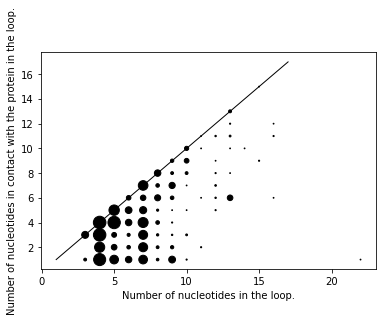

In [182]:
import numpy as np
x = []
y = []
points_size = []
for ii in length_contact.keys():
    for jj in range(len(list(length_contact[ii].keys()))):
        x.append(ii)
    for kk in length_contact[ii].keys():
        y.append(kk)
        points_size.append(length_contact[ii][kk])

z= [x/1.5 for x in points_size]
#z = [pow(1.25,x) for x in z]
print(x,y)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y,c="black", s=z)
plt.plot([1,17],[1,17],'k-',lw=1)
plt.xlabel("Number of nucleotides in the loop.", color="black")
plt.ylabel("Number of nucleotides in contact with the protein in the loop.", color="black")

plt.savefig("hairpin_fig_contact.png")

## Supplementary

Those are the supplementary data and figures of the paper.

The first filter selects all the single-stranded
nucleotides in contact with a protein (Suppl. XXX). To that end, two sets are constructed: 
one containing all the single-stranded nucleotides and one
containing all the nucleotides at the protein interface. Then the intersection
of these two sets is kept. As a result, 195,523 nucleotides are obtained from
1957 PDB structures (100 per PDB structure on average).

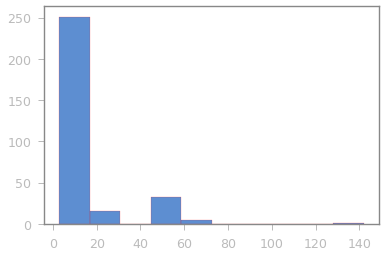

In [128]:
plt.hist(ss, alpha=.8, edgecolor='red')
#plt.hist(mixte, alpha=.7, edgecolor='yellow')
plt.show()

In [88]:
letter = ["A", "U", "G", "C"]
resultats_all = {}
for ii in letter:
    for jj in letter:
        for kk in letter:
            resultats_all[ii+jj+kk] = {}

for key in fragments.keys():
    for key2 in fragments[key].keys():
        model = "model_" + str(fragments[key][key2]["model"])
        chain = "chain_" + str(fragments[key][key2]["chain"])
        seq = fragments[key][key2]['seq']
        contact = False
        interface = set()
        nucl2=[]
        mapping_rev={}
        for nn in structures[fragments[key][key2]['structure']]["mapping"][chain].keys():
            mapping_rev[structures[fragments[key][key2]['structure']]["mapping"][chain][nn]] = nn
        for nucl in structures[fragments[key][key2]['structure']]["interface_protein"]["model_1"][chain].keys():
            tmp = nucl.split('_')[1]
            interface.add(structures[fragments[key][key2]['structure']]["mapping"][chain][tmp])
        ss=True
        ds=0
        for nucl in fragments[key][key2]['resid']:
            if nucl in interface:
                contact = True
            nucl2.append(mapping_rev[nucl])
        for nucl in nucl2:
            if structures[fragments[key][key2]['structure']]["ss"][chain]["res_"+nucl][0]=="D":
                ss=False
                ds+=1
        if fragments[key][key2]['clust1.0'] not in resultats_all[seq].keys():
            resultats_all[seq][fragments[key][key2]['clust1.0']] = {"contact_ss":0, "contact_ds":0, "contact_mixte":0, "nocontact_ss":0, "nocontact_ds":0, "nocontact_mixte":0}
        if contact:
            if ss:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["contact_ss"] += 1
            elif ds == 3:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["contact_ds"] += 1
            else:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["contact_mixte"] += 1
        else:
            if ss:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["nocontact_ss"] += 1
            elif ds == 3:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["nocontact_ds"] += 1
            else:
                resultats_all[seq][fragments[key][key2]['clust1.0']]["nocontact_mixte"] += 1
        

In [89]:
letter = ["A", "U", "G", "C"]
resultats_all_bis = {}
for ii in letter:
    for jj in letter:
        for kk in letter:
            resultats_all_bis[ii+jj+kk] = {}
            
for key in resultats_all.keys():
    con_ss = 0
    sum_con_ss = 0
    con_ds = 0
    sum_con_ds = 0
    con_mixte = 0
    sum_con_mixte = 0
    nocon_ss = 0
    sum_nocon_ss = 0
    nocon_ds = 0
    sum_nocon_ds = 0
    nocon_mixte = 0
    sum_nocon_mixte = 0
    mixte_ss = 0
    sum_mixte_ss = 0
    mixte_ds = 0
    sum_mixte_ds = 0
    mixte_mixte = 0
    sum_mixte_mixte=0
    j = 0
    print(key)
    for clust in resultats_all[key].keys():
        j += 1
        if resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["contact_ds"] + resultats_all[key][clust]["contact_mixte"] + resultats_all[key][clust]["nocontact_ss"] + resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["nocontact_mixte"] > 2:
            if resultats_all[key][clust]["nocontact_mixte"] == 0 and resultats_all[key][clust]["nocontact_ds"] == 0 and resultats_all[key][clust]["nocontact_ss"] == 0:
                #print(clust, results[key][clust])
                if resultats_all[key][clust]["contact_mixte"] > 0:
                    con_mixte += 1
                    sum_con_mixte += resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["contact_ds"] + resultats_all[key][clust]["contact_mixte"]
                else:
                    if resultats_all[key][clust]["contact_ds"] == 0:
                        con_ss += 1
                        sum_con_ss += resultats_all[key][clust]["contact_ss"]
                    else:
                        con_ds += 1
                        sum_con_ds += resultats_all[key][clust]["contact_ds"]
            elif resultats_all[key][clust]["contact_ss"] == 0 and resultats_all[key][clust]["contact_ds"] == 0 and resultats_all[key][clust]["contact_mixte"] == 0:
                if resultats_all[key][clust]["nocontact_mixte"] > 0:
                    nocon_mixte += 1
                    sum_nocon_mixte += resultats_all[key][clust]["nocontact_ss"] + resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["nocontact_mixte"]
                else:
                    if resultats_all[key][clust]["nocontact_ss"] == 0:
                        nocon_ds += 1
                        sum_nocon_ds += resultats_all[key][clust]["nocontact_ds"]
                    else:
                        nocon_ss += 1
                        sum_nocon_ss += resultats_all[key][clust]["nocontact_ss"]

            else:
                if resultats_all[key][clust]["nocontact_mixte"] > 0 or resultats_all[key][clust]["contact_mixte"] > 0 or (resultats_all[key][clust]["nocontact_ss"] != 0 and resultats_all[key][clust]["nocontact_ds"] !=0) or (resultats_all[key][clust]["contact_ss"] != 0 or resultats_all[key][clust]["contact_ds"] !=0):
                    mixte_mixte += 1
                    sum_mixte_mixte += resultats_all[key][clust]["nocontact_ss"] + resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["nocontact_mixte"] + resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["contact_ds"] + resultats_all[key][clust]["contact_mixte"]
                else:
                    if resultats_all[key][clust]["contact_ss"] == 0 and resultats_all[key][clust]["nocontact_ss"] == 0:
                        mixte_ds += 1
                        sum_mixte_ds += resultats_all[key][clust]["nocontact_ds"] + resultats_all[key][clust]["contact_ds"]
                    else:
                        mixte_ss += 1
                        sum_mixte_ss += resultats_all[key][clust]["contact_ss"] + resultats_all[key][clust]["nocontact_ss"]             

    resultats_all_bis[key] = {"contact_ss":con_ss, "contact_ds":con_ds, "contact_mixte":con_mixte, "nocontact_ss":nocon_ss, "nocontact_ds":nocon_ds, "nocontact_mixte":nocon_mixte, "mixte_ss":mixte_ss, "mixte_ds":mixte_ds, "mixte_mixte":mixte_mixte, \
                   "sum_contact_ss":sum_con_ss, "sum_contact_ds":sum_con_ds, "sum_contact_mixte":sum_con_mixte, \
                   "sum_nocontact_ss":sum_nocon_ss, "sum_nocontact_ds":sum_nocon_ds, "sum_nocontact_mixte":sum_nocon_mixte,\
                   "sum_mixte_ss":sum_mixte_ss, "sum_mixte_ds":sum_mixte_ds, "sum_mixte_mixte":sum_mixte_mixte}
    

AAA
AAU
AAG
AAC
AUA
AUU
AUG
AUC
AGA
AGU
AGG
AGC
ACA
ACU
ACG
ACC
UAA
UAU
UAG
UAC
UUA
UUU
UUG
UUC
UGA
UGU
UGG
UGC
UCA
UCU
UCG
UCC
GAA
GAU
GAG
GAC
GUA
GUU
GUG
GUC
GGA
GGU
GGG
GGC
GCA
GCU
GCG
GCC
CAA
CAU
CAG
CAC
CUA
CUU
CUG
CUC
CGA
CGU
CGG
CGC
CCA
CCU
CCG
CCC


In [91]:
for motif in resultats_all_bis.keys():
    print(motif, (resultats_all_bis[motif]["sum_contact_ss"]+resultats_all_bis[motif]["sum_contact_ds"]+resultats_all_bis[motif]["sum_contact_mixte"])/(resultats_all_bis[motif]["sum_contact_ss"]+resultats_all_bis[motif]["sum_contact_ds"]+resultats_all_bis[motif]["sum_contact_mixte"]+resultats_all_bis[motif]["sum_mixte_ss"]+resultats_all_bis[motif]["sum_mixte_ds"]+resultats_all_bis[motif]["sum_mixte_mixte"]+resultats_all_bis[motif]["sum_nocontact_ss"]+resultats_all_bis[motif]["sum_nocontact_ds"]+resultats_all_bis[motif]["sum_nocontact_mixte"]))

AAA 0.2796524550414225
AAU 0.2799347471451876
AAG 0.22372274650178978
AAC 0.20149099192379374
AUA 0.31483578708946774
AUU 0.1837270341207349
AUG 0.1866980885048442
AUC 0.23440795420307323
AGA 0.21806397658373405
AGU 0.23530736320648502
AGG 0.11259079903147699
AGC 0.15516381174122734
ACA 0.261929732564237
ACU 0.10022558814050918
ACG 0.20140721196130168
ACC 0.12569351444423188
UAA 0.14385644768856448
UAU 0.20894736842105263
UAG 0.20995962314939434
UAC 0.18112
UUA 0.1483704974271012
UUU 0.2555746140651801
UUG 0.10229482691559705
UUC 0.16666666666666666
UGA 0.21922626025791325
UGU 0.1316883116883117
UGG 0.12134217713616856
UGC 0.14733369983507422
UCA 0.19263759828448893
UCU 0.10160734787600459
UCG 0.21428571428571427
UCC 0.11023985239852399
GAA 0.211905108426721
GAU 0.25925036040365207
GAG 0.16661790520772382
GAC 0.21008559732043172
GUA 0.165375854214123
GUU 0.10122699386503067
GUG 0.1502260927817786
GUC 0.14708540442837778
GGA 0.14081249096429088
GGU 0.0881766600214691
GGG 0.0855581770768

In [59]:
print(len(hairpins))
i = 0
for key in results_hairpins.keys():
    for chain in results_hairpins[key].keys():
        i += 1
        if results_hairpins[key][chain]['contact_ss'] + results_hairpins[key][chain]['nocontact'] + results_hairpins[key][chain]['contact_ds'] - 6 > 14:
            res = []
            for line in hairpins:
                if line[0] == key:
                    res.append(line)
            print(results_hairpins[key][chain]['contact_ss'], res[chain])
print(i)

1136
15 ['6DU4', 'B', 5, 25, 'GGCGUAGGCUACAGAGAAGCC']
9 ['2ANR', 'B', 203, 223, 'CGCGGAUCAGUCACCCAAGCG']
11 ['6RTIB', 'X', 13, 34, 'GACCUGACUUCUAUACUAAGUC']
248


In [60]:
print(len(hairpins))
j = 0
i = 0
for key in results_hairpins.keys():
    for chain in results_hairpins[key].keys():
        boole = False
        bool_l = False
        for line in hairpins:
            if results_hairpins[key][chain]['contact_ss'] + results_hairpins[key][chain]['nocontact'] + results_hairpins[key][chain]['contact_ds']- 6 <= 6:
                bool_l = True
                if line[0] == key and len(line[-1]) - 6 == results_hairpins[key][chain]['contact_ss']:
                    res.append(line)
                    boole = True
        if boole:
            i+= 1
        if bool_l:
            j+= 1
            
print(i, j)

1136
60 122


In [61]:
#print(structures["1XMQ"]["mapping"]["chain_A"])
for key in structures["5IT9"]["ss"]["chain_i"].keys():
    try:
        if int(structures["5IT9"]["mapping"]["chain_i"][key.split('_')[1]]) < 6198 and int(structures["5IT9"]["mapping"]["chain_i"][key.split('_')[1]]) > 6178:
            print(int(structures["5IT9"]["mapping"]["chain_i"][key.split('_')[1]]),structures["5IT9"]["ss"]["chain_i"][key])
    except:
        pass

6179 ['D', 150, 185]
6180 ['D', 151, 185]
6181 ['D', 0, 0]
6182 ['L', 2, 13]
6183 ['L', 3, 13]
6184 ['L', 4, 13]
6185 ['L', 5, 13]
6186 ['L', 6, 13]
6187 ['L', 7, 13]
6188 ['L', 8, 13]
6189 ['L', 9, 13]
6190 ['L', 10, 13]
6191 ['L', 11, 13]
6192 ['L', 12, 13]
6193 ['L', 13, 13]
6194 ['L', 14, 13]
6195 ['D', 0, 0]
6196 ['D', 167, 185]
6197 ['D', 168, 185]


In [62]:
for key in structures["3PIP"]["ss"]["chain_X"].keys():
    try:
        if int(structures["3PIP"]["mapping"]["chain_X"][key.split('_')[1]]) < 188 and int(structures["3PIP"]["mapping"]["chain_X"][key.split('_')[1]]) > 162:
            print(int(structures["3PIP"]["mapping"]["chain_X"][key.split('_')[1]]),structures["3PIP"]["ss"]["chain_X"][key])
    except:
        pass

163 ['D', 163, 2644]
164 ['D', 164, 2644]
165 ['D', 0, 0]
166 ['L', 2, 19]
167 ['L', 3, 19]
168 ['L', 4, 19]
169 ['L', 5, 19]
170 ['L', 6, 19]
171 ['L', 7, 19]
172 ['L', 8, 19]
173 ['L', 9, 19]
174 ['L', 10, 19]
175 ['L', 11, 19]
176 ['L', 12, 19]
177 ['L', 13, 19]
178 ['L', 14, 19]
179 ['L', 15, 19]
180 ['L', 16, 19]
181 ['L', 17, 19]
182 ['L', 18, 19]
183 ['L', 19, 19]
184 ['L', 20, 19]
185 ['D', 0, 0]
186 ['D', 186, 2644]
187 ['D', 187, 2644]


In [14]:
for hh in results_hairpins.keys():
    for kk in results_hairpins[hh].keys():
        #if results_hairpins[hh][kk]['nocontact'] + results_hairpins[hh][kk]['contact_ds'] -6> 0:
        for line in hairpins:
            res = []
            if line[0] == hh:
                res.append(line)
            if kk < len(res):
                print(res[kk])
        #    for hairpin in hairpins:
         #       if hairpin[0] == hh:
          #          print(hairpin)

['6YS3', 'b', 303, 314, 'GUCUGGAAAGGC']
['6YS3', 'b', 1450, 1465, 'GGGCGACGGUUGUCCC']
['6YS3', 'b', 2305, 2319, 'CUGGUCGGACAUCAG']
['6YS3', 'b', 2797, 2807, 'CUCCUUGAGAG']
['6YS3', 'b', 1531, 1544, 'GGCACUACGGUGCU']
['6YS3', 'b', 1170, 1183, 'GACGCUUAUGCGUU']
['6YS3', 'v', 50, 62, 'GGGUUCGAUUCCC']
['6YS3', 'b', 2211, 2221, 'CCCUGAUCGGG']
['5Y58', 'Z', 295, 307, 'GAUGGCUAAAAUC']
['3OW2', '0', 491, 501, 'CCUCAGAAGGG']
['3OW2', '0', 2387, 2401, 'UCUUCCCAACGAGGA']
['3OW2', '0', 2874, 2883, 'GAGGUAACGA']
['3OW2', '0', 1703, 1715, 'GGCGGCGAAAGCC']
['3OW2', '0', 2778, 2796, 'AGCUGAACGCAUCUAAGCU']
['3OW2', '0', 2735, 2744, 'UUCGAGAGAG']
['3OW2', '0', 250, 259, 'CCCUCACGGG']
['3OW2', '0', 388, 401, 'GGGUUGGAUAUCCC']
['3OW2', '0', 1466, 1476, 'CCGCAACUCGA']
['3OW2', '0', 1385, 1397, 'GGGUGAGAACCCC']
['3OW2', '0', 1791, 1801, 'UCCGGAACGGA']
['3OW2', '0', 1324, 1333, 'GGUGAAAACU']
['3OW2', '0', 1496, 1509, 'GGGUUAAUAUUCCC']
['3OW2', '0', 2504, 2516, 'AGAGCACAUAUCG']
['3OW2', '0', 215, 225, 'AACCGC

In [67]:
proportion = []
for hairpin in results_hairpins.values():
    for chain in hairpin.values():
        proportion.append(round((chain["contact_ss"]+chain["contact_ds"])/(chain["contact_ss"]+chain["contact_ds"]+chain["nocontact"]), 2))

In [30]:
plt.hist(proportion)
plt.show()

In [32]:
bench_ds_contact = []
for ii in results_hairpins.keys():
    for jj in results_hairpins[ii].keys():
        if results_hairpins[ii][jj]['contact_ds'] < 2:
            k = 0
            for item in hairpins:
                if item[0] == ii:
                    if k == jj:
                        bench_ds_contact.append(item)
                    k += 1
            

In [33]:
bench_ds_contact

[['3OW2', '0', 1988, 2000, 'CGCAUCAGUAGCG'],
 ['3OW2', '0', 2584, 2594, 'GGUUGUUCGCC'],
 ['3OW2', '0', 731, 740, 'UCUUCAAGGG'],
 ['3OW2', '0', 2561, 2572, 'CGUGCAGAAGCG'],
 ['3OW2', '0', 1272, 1284, 'CCACUCAUACUGG'],
 ['6SPB', 'A', 531, 543, 'CCUACUUGUUAGG'],
 ['6YT9', '2', 290, 299, 'UCUGAGAGGA'],
 ['6YT9', '2', 314, 331, 'GGGACUGAGACACGGCCC'],
 ['6YSI', '1', 156, 170, 'CAUGAAUACAUAGUG'],
 ['6YSI', '1', 533, 543, 'ACCUUUGUGGU'],
 ['6YSI', '1', 1436, 1451, 'UGGCGUUGGUUGUCCA'],
 ['6YSI', '1', 630, 640, 'UCUUAAUAGGG'],
 ['6YSI', '1', 1267, 1279, 'GGGUGAAAAACCC'],
 ['6YSI', '1', 2196, 2206, 'CCGUGAUCCGG'],
 ['1QF6', 'B', 29, 41, 'GCAUUCGUAAUGC'],
 ['3BT7', 'C', 50, 64, 'UGUGUUCGAUCCACA'],
 ['6TMF', 'A', 396, 404, 'GGCAACGCC'],
 ['1H4S', 'T', 30, 40, 'CGUUCGGGACG'],
 ['2FK6', 'R', 11, 24, 'CUCAGCAGGUAGAG'],
 ['6XZ7B', 'g', 51, 63, 'GUGUUCGAUCCAC'],
 ['6XZ7B', 'A', 1090, 1101, 'AGCGUAAUAGCU'],
 ['4JXX', 'B', 929, 941, 'GGAUUCUGAUUCC'],
 ['5VOF', 'A', 13, 24, 'GAGAUAAUACUU'],
 ['6F4H', 'F', 

In [72]:
for key in res_bis.keys():
    sum_tt = res_bis[key]['sum_contact_ss']+res_bis[key]['sum_contact_ds']+res_bis[key]['sum_contact_mixte']+res_bis[key]['sum_nocontact_ss']+res_bis[key]['sum_nocontact_ds']+res_bis[key]['sum_nocontact_mixte']+res_bis[key]['sum_mixte_ss']+res_bis[key]['sum_mixte_ds']+res_bis[key]['sum_mixte_mixte']
    texte = []
    texte.append("\hline")
    texte.append("{} & ss & mixed & ds   & total \\\\ \hline".format(key))
    texte.append("contact   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_bis[key]['contact_ss'], res_bis[key]['sum_contact_ss'], res_bis[key]['contact_mixte'], res_bis[key]['sum_contact_mixte'], res_bis[key]['contact_ds'], res_bis[key]['sum_contact_ds'], str(res_bis[key]['contact_ss']+res_bis[key]['contact_mixte']+res_bis[key]['contact_ds']), str(res_bis[key]['sum_contact_ss']+res_bis[key]['sum_contact_mixte']+res_bis[key]['sum_contact_ds'])))
    texte.append("mixed   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_bis[key]['mixte_ss'], res_bis[key]['sum_mixte_ss'], res_bis[key]['mixte_mixte'], res_bis[key]['sum_mixte_mixte'],  res_bis[key]['mixte_ds'], res_bis[key]['sum_mixte_ds'], str(res_bis[key]['mixte_ss']+res_bis[key]['mixte_mixte']+res_bis[key]['mixte_ds']), str(res_bis[key]['sum_mixte_ss']+res_bis[key]['sum_mixte_mixte']+res_bis[key]['sum_mixte_ds'])))
    texte.append("nocontact   {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_bis[key]['nocontact_ss'], res_bis[key]['sum_nocontact_ss'], res_bis[key]['nocontact_mixte'], res_bis[key]['sum_nocontact_mixte'], res_bis[key]['nocontact_ds'], res_bis[key]['sum_nocontact_ds'], str(res_bis[key]['nocontact_ss']+res_bis[key]['nocontact_mixte']+res_bis[key]['nocontact_ds']), str(res_bis[key]['sum_nocontact_ss']+res_bis[key]['sum_nocontact_mixte']+res_bis[key]['sum_nocontact_ds'])))
    texte.append("total   & {}({}) & {}({})   & {}({}) & {}({})  \\\\ \hline".format(res_bis[key]['contact_ss']+res_bis[key]['mixte_ss']+res_bis[key]['nocontact_ss'], str(res_bis[key]['sum_contact_ss']+res_bis[key]['sum_mixte_ss']+res_bis[key]['sum_nocontact_ss']), res_bis[key]['contact_mixte']+res_bis[key]['mixte_mixte']+res_bis[key]['nocontact_mixte'], res_bis[key]['sum_contact_mixte']+res_bis[key]['sum_mixte_mixte']+res_bis[key]['sum_nocontact_mixte'], res_bis[key]['contact_ds']+res_bis[key]['mixte_ds']+res_bis[key]['nocontact_ds'], res_bis[key]['sum_contact_ds']+res_bis[key]['sum_mixte_ds']+res_bis[key]['sum_nocontact_ds'], str(res_bis[key]['contact_ss']+res_bis[key]['contact_mixte']+res_bis[key]['contact_ds']+res_bis[key]['mixte_ss']+res_bis[key]['mixte_mixte']+res_bis[key]['mixte_ds']+res_bis[key]['nocontact_ss']+res_bis[key]['nocontact_mixte']+res_bis[key]['nocontact_ds']), sum_tt))
    for ii in texte:
        print(ii)

\hline
AAA & ss & mixed & ds   & total \\ \hline
contact   & 562(5587) & 597(8169)   & 13(99) & 1172(13855)  \\ \hline
mixed   & 0(0) & 1382(141370)   & 0(0) & 1382(141370)  \\ \hline
nocontact   178(1058) & 374(2695)   & 7(35) & 559(3788)  \\ \hline
total   & 740(6645) & 2353(152234)   & 20(134) & 3113(159013)  \\ \hline
\hline
AAC & ss & mixed & ds   & total \\ \hline
contact   & 338(3419) & 438(5467)   & 10(223) & 786(9109)  \\ \hline
mixed   & 0(0) & 1006(110234)   & 0(0) & 1006(110234)  \\ \hline
nocontact   146(754) & 245(2083)   & 8(40) & 399(2877)  \\ \hline
total   & 484(4173) & 1689(117784)   & 18(263) & 2191(122220)  \\ \hline
\hline
ACA & ss & mixed & ds   & total \\ \hline
contact   & 326(3077) & 416(5190)   & 6(44) & 748(8311)  \\ \hline
mixed   & 0(0) & 892(95738)   & 0(0) & 892(95738)  \\ \hline
nocontact   178(1050) & 193(1574)   & 5(44) & 376(2668)  \\ \hline
total   & 504(4127) & 1501(102502)   & 11(88) & 2016(106717)  \\ \hline
\hline
ACC & ss & mixed & ds   & total